In [9]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from collections import Counter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, learning_curve
import warnings
from matplotlib.pyplot import ylim
from sklearn.feature_selection import RFE

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

In [2]:
cv = StratifiedKFold(n_splits=5,random_state=42)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
  
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    return plt

In [3]:
dataset = pd.read_csv('43featuresTrainNum881.csv',index_col=0)
test = pd.read_csv('test.csv')
PassengerId = test['PassengerId']
train_len = 881
print dataset.columns

Index([u'Survived', u'Sex', u'SibSp1', u'SibSp2', u'SibSp3', u'SibSp4',
       u'Parch1', u'Parch2', u'Parch3', u'Parch4', u'Fsize1', u'Fsize2',
       u'Fsize3', u'Fsize4', u'Fsize5', u'Title_Master', u'Title_girl',
       u'Title_men', u'Title_women', u'Em_C', u'Em_Q', u'Em_S', u'Cabin_B',
       u'Cabin_C', u'Cabin_D', u'Cabin_E', u'Cabin_X', u'T_A', u'T_C', u'T_P',
       u'T_S', u'T_X', u'age_0', u'age_1', u'age_2', u'age_3', u'age_4',
       u'Fare_0', u'Fare_1', u'Fare_2', u'Fare_3', u'Pc_1', u'Pc_2', u'Pc_3'],
      dtype='object')


In [4]:
pdtest = dataset[train_len:].drop(labels=["Survived"],axis = 1)
y_train = dataset[:train_len]["Survived"].values.astype(int)
pdx_train = dataset[:train_len].drop(labels = ["Survived"],axis = 1)

test = pdtest.values
x_train = pdx_train.values

xtrain, xtest, ytrain, ytest = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
print x_train.shape
print y_train.shape
print test.shape
print xtrain.shape
print ytrain.shape
print xtest.shape
print ytest.shape

(881, 43)
(881,)
(418, 43)
(590, 43)
(590,)
(291, 43)
(291,)


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1298
Data columns (total 44 columns):
Survived        881 non-null float64
Sex             1299 non-null int64
SibSp1          1299 non-null int64
SibSp2          1299 non-null int64
SibSp3          1299 non-null int64
SibSp4          1299 non-null int64
Parch1          1299 non-null int64
Parch2          1299 non-null int64
Parch3          1299 non-null int64
Parch4          1299 non-null int64
Fsize1          1299 non-null int64
Fsize2          1299 non-null int64
Fsize3          1299 non-null int64
Fsize4          1299 non-null int64
Fsize5          1299 non-null int64
Title_Master    1299 non-null int64
Title_girl      1299 non-null int64
Title_men       1299 non-null int64
Title_women     1299 non-null int64
Em_C            1299 non-null int64
Em_Q            1299 non-null int64
Em_S            1299 non-null int64
Cabin_B         1299 non-null int64
Cabin_C         1299 non-null int64
Cabin_D         1299 non-nul

In [88]:
param_grid = dict(gamma=np.logspace(-3, 3, 100), C=np.logspace(-3, 3, 100),kernel=['rbf'])
cv = StratifiedKFold(n_splits=5,random_state=42)
gridsvc2 = GridSearchCV(SVC(), param_grid=param_grid, scoring='accuracy',cv=cv,n_jobs=-1, verbose = 1)
gridsvc2.fit(x_train, y_train)
print("The best parameters are %s with a score of %0.8f"% \
      (gridsvc2.best_params_, gridsvc2.best_score_))

#print gridsvc2.cv_results_['param_C']
#print gridsvc2.cv_results_['param_gamma']
#print gridsvc2.cv_results_['mean_test_score']
#sns.barplot(x='param_C',y='mean_test_score',hue='param_gamma',data=gridsvc2.cv_results_)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 12076 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 14376 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 16876 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 19576 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 22476 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 25576 tasks      | elapse

The best parameters are {'kernel': 'rbf', 'C': 1.0722672220103231, 'gamma': 0.086974900261778343} with a score of 0.83087401


In [91]:
parameter_grid = {
             'max_depth' : [4,6,8,10,12,14,16],
             'n_estimators': [750],
             'min_samples_split': [10,20,40,80],
             'min_samples_leaf': [10,15,20],
            'max_features':[4,5,6,7,8,9,10,11,12], 
            'oob_score':[True]
             }
rft = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(estimator=rft,
                           param_grid=parameter_grid,n_jobs=-1,
                           cv=StratifiedKFold(n_splits=5,random_state=42), verbose = 1)

grid_search.fit(x_train, y_train)
parameters = grid_search.best_params_

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 48.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 65.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 86.0min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 101.8min finished


Best score: 0.826333711691
Best parameters: {'oob_score': True, 'min_samples_leaf': 10, 'n_estimators': 750, 'min_samples_split': 40, 'max_features': 10, 'max_depth': 10}


In [89]:
from sklearn.tree import DecisionTreeClassifier
adaDTC = AdaBoostClassifier(DecisionTreeClassifier(), random_state=7)
ada_param_grid = {
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[400, 700, 1000],
              "learning_rate":  [0.0001,0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, 
                        cv=StratifiedKFold(n_splits=5,random_state=42), 
                        scoring='accuracy', n_jobs= -1, verbose = 1)

gsadaDTC.fit(x_train,y_train)

print gsadaDTC.best_score_
print gsadaDTC.best_params_

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  5.5min finished


0.796821793417
{'n_estimators': 1000, 'learning_rate': 0.2, 'algorithm': 'SAMME'}


In [92]:
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [4,6,8,10,12,14,16],
              "max_features": [4,5,6,7,8,9,10,11,12],
              'min_samples_split': [10,20,40,80],
             'min_samples_leaf': [10,15,20],
              "bootstrap": [False],
              "n_estimators" :[750],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, 
                      cv=StratifiedKFold(n_splits=5,random_state=42), 
                      scoring='accuracy', n_jobs= -1, verbose = 1)

gsExtC.fit(x_train,y_train)


# Best score
print gsExtC.best_score_
print gsExtC.best_params_

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 45.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 61.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 81.1min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 96.1min finished


0.83087400681
{'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 750, 'min_samples_split': 80, 'criterion': 'gini', 'max_features': 11, 'max_depth': 6}


In [93]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [750],
              'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
              "max_depth": [4,6,8,10,12,14,16],
              'min_samples_leaf': [10,15,20],
              "max_features": [4,5,6,7,8,9,10,11,12],
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, 
                     cv=StratifiedKFold(n_splits=5,random_state=42), 
                     scoring='accuracy', n_jobs= -1, verbose = 1)

gsGBC.fit(x_train,y_train)


print gsGBC.best_score_
print gsGBC.best_params_

Fitting 5 folds for each of 945 candidates, totalling 4725 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 4725 out of 4725 | elapsed: 34.0min finished


0.83541430193
{'loss': 'deviance', 'learning_rate': 0.001, 'min_samples_leaf': 10, 'n_estimators': 750, 'max_features': 12, 'max_depth': 12}


In [71]:
for i in range(5):
    print grid_search.cv_results_['split%d_test_score' % i]
grid_search.cv_results_['mean_test_score']

[ 0.84180791  0.83615819  0.84180791 ...,  0.83050847  0.83615819
  0.83050847]
[ 0.81818182  0.81818182  0.81818182 ...,  0.8125      0.8125      0.8125    ]
[ 0.8125  0.8125  0.8125 ...,  0.8125  0.8125  0.8125]
[ 0.79545455  0.79545455  0.79545455 ...,  0.8125      0.8125      0.80681818]
[ 0.83522727  0.84090909  0.84090909 ...,  0.84659091  0.84659091
  0.84659091]


array([ 0.82065834,  0.82065834,  0.82179342, ...,  0.82292849,
        0.82406356,  0.82179342])

In [97]:
from sklearn.metrics import accuracy_score
n_splits = 5
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((x_train.shape[0],))
    skf = StratifiedKFold(n_splits=n_splits,random_state=42)
    skf.get_n_splits(x_train,y_train)
    oof_test = np.zeros((x_test.shape[0],))

    for train_index, test_index in skf.split(x_train,y_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test += clf.predict(x_test)
        

    oof_test = oof_test / n_splits
    print accuracy_score(y_train,oof_train.reshape(-1))
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

0.828603859251


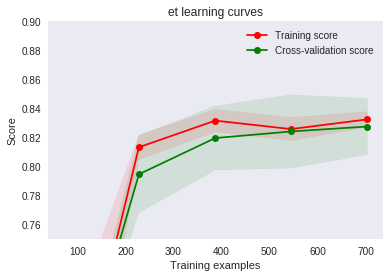

In [111]:
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}
et_params = {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 
             'min_samples_split': 9, 'criterion': 'gini', 'max_features': 2, 
             'max_depth': None}
et_params={'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 750, 'min_samples_split': 80, 
           'criterion': 'gini', 'max_features': 11, 'max_depth': 6}
et = ExtraTreesClassifier(**et_params)
et_oof_train, et_oof_test = get_oof(et,x_train,y_train,test)
g = plot_learning_curve(et,"et learning curves",x_train,y_train,cv=cv,ylim=ylim(0.75,0.9),
                       train_sizes=np.linspace(.1, 1.0, 5))

0.824063564132


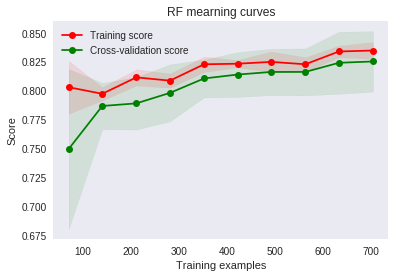

In [95]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'oob_score' : True,
    'max_depth': 6,
    'min_samples_leaf': 15,
    'max_features' : 'sqrt',
    'verbose': 0
}
#0.850170261067 
rf_params={'oob_score': True, 'min_samples_leaf': 10, 'n_estimators': 750, 
           'min_samples_split': 40, 'max_features': 10, 'max_depth': 10}
#0.82633
rf = RandomForestClassifier(**rf_params)
rf_oof_train, rf_oof_test = get_oof(rf,x_train,y_train,test)
g = plot_learning_curve(rf,"RF mearning curves",x_train,y_train,cv=cv,train_sizes=np.linspace(.1, 1.0, 10))

0.820658342792


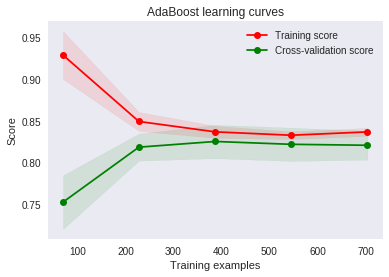

In [99]:
ada_params = {
    'n_estimators': 1000,
    'learning_rate' : 0.02
}
'''ada_params = {'n_estimators': 700, 'learning_rate': 0.2, 
 'algorithm': 'SAMME'}'''
ada = AdaBoostClassifier(DecisionTreeClassifier(),**ada_params)
ada = AdaBoostClassifier(**ada_params)
ada_oof_train, ada_oof_test = get_oof(ada,x_train,y_train,test)
g = plot_learning_curve(ada,"AdaBoost learning curves",x_train,y_train,cv=cv)

0.83314415437


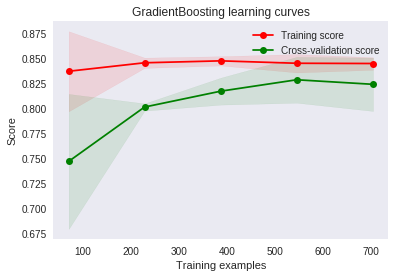

In [96]:
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}
#More trees is always better with diminishing returns. Deeper trees are almost always better
#subject to requiring more trees for similar performance.

#The above two points are directly a result of the bias-variance tradeoff. 
#Deeper trees reduces the bias; more trees reduces the variance.
gb_params={'loss': 'deviance', 'learning_rate': 0.001, 'min_samples_leaf': 10, 
           'n_estimators': 750, 'max_features': 12, 'max_depth': 12}
#0.8354
gb = GradientBoostingClassifier(**gb_params)
gb_oof_train, gb_oof_test = get_oof(gb,x_train,y_train,test)
g = plot_learning_curve(gb,"GradientBoosting learning curves",x_train,y_train,cv=cv)

0.83087400681


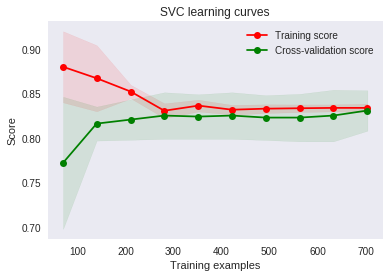

In [94]:
svc_params = {'kernel': 'rbf', 'C': 13.219411484660288, 'gamma': 0.0030538555088334154}
#svc_params = {'kernel': 'rbf', 'C': 869.74900261778339, 'gamma': 0.0023101297000831605}
svc_params = {'kernel': 'rbf', 'C': 1.0722672220103231, 'gamma': 0.086974900261778343}
#0.8308
svc = SVC(**svc_params)
svc_oof_train, svc_oof_test = get_oof(svc,x_train,y_train,test)
g = plot_learning_curve(svc,"SVC learning curves",x_train,y_train,cv=cv,
                        train_sizes=np.linspace(.1, 1.0, 10))

**Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature_importances_**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [100]:
rf_features = rf.feature_importances_
et_features = et.feature_importances_
ada_features = ada.feature_importances_
gb_features = gb.feature_importances_
'''print len(gb_features)
print gb_features
print len(ada_features)
print et_features
print rf_features'''

'print len(gb_features)\nprint gb_features\nprint len(ada_features)\nprint et_features\nprint rf_features'

In [101]:
cols = dataset.columns.values[1:]
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'rf': rf_features,
     'et': et_features,
      'ada': ada_features,
    'gb': gb_features
    })
feature_dataframe = feature_dataframe[['features','rf','et','ada','gb']]
feature_dataframe.head()

,features,rf,et,ada,gb
0,Sex,0.237091,0.225014,0.015,0.192265
1,SibSp1,0.004279,0.002207,0.000,0.003980
2,SibSp2,0.004637,0.001744,0.000,0.004024
3,SibSp3,0.000045,0.000000,0.003,0.000066
4,SibSp4,0.009781,0.015756,0.016,0.017013


**Interactive feature importances via Plotly scatterplots**

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers 

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe

In [102]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)
feature_dataframe.sort_values('et',ascending=False)
important = feature_dataframe.sort_values('mean',ascending=False)
#print important
important['features'].values

array(['Title_men', 'Sex', 'Pc_3', 'Fsize5', 'Title_girl', 'Title_women',
       'Cabin_X', 'Pc_1', 'Fare_2', 'Fare_1', 'T_S', 'SibSp4',
       'Title_Master', 'age_3', 'Cabin_D', 'Pc_2', 'Em_S', 'Cabin_B',
       'Parch4', 'age_4', 'Cabin_E', 'Cabin_C', 'Em_C', 'Fsize1', 'age_0',
       'age_1', 'Em_Q', 'T_A', 'T_X', 'Parch2', 'Fsize3', 'Parch1',
       'SibSp1', 'SibSp2', 'age_2', 'Fsize2', 'T_P', 'Parch3', 'SibSp3',
       'Fare_3', 'Fsize4', 'T_C', 'Fare_0'], dtype=object)

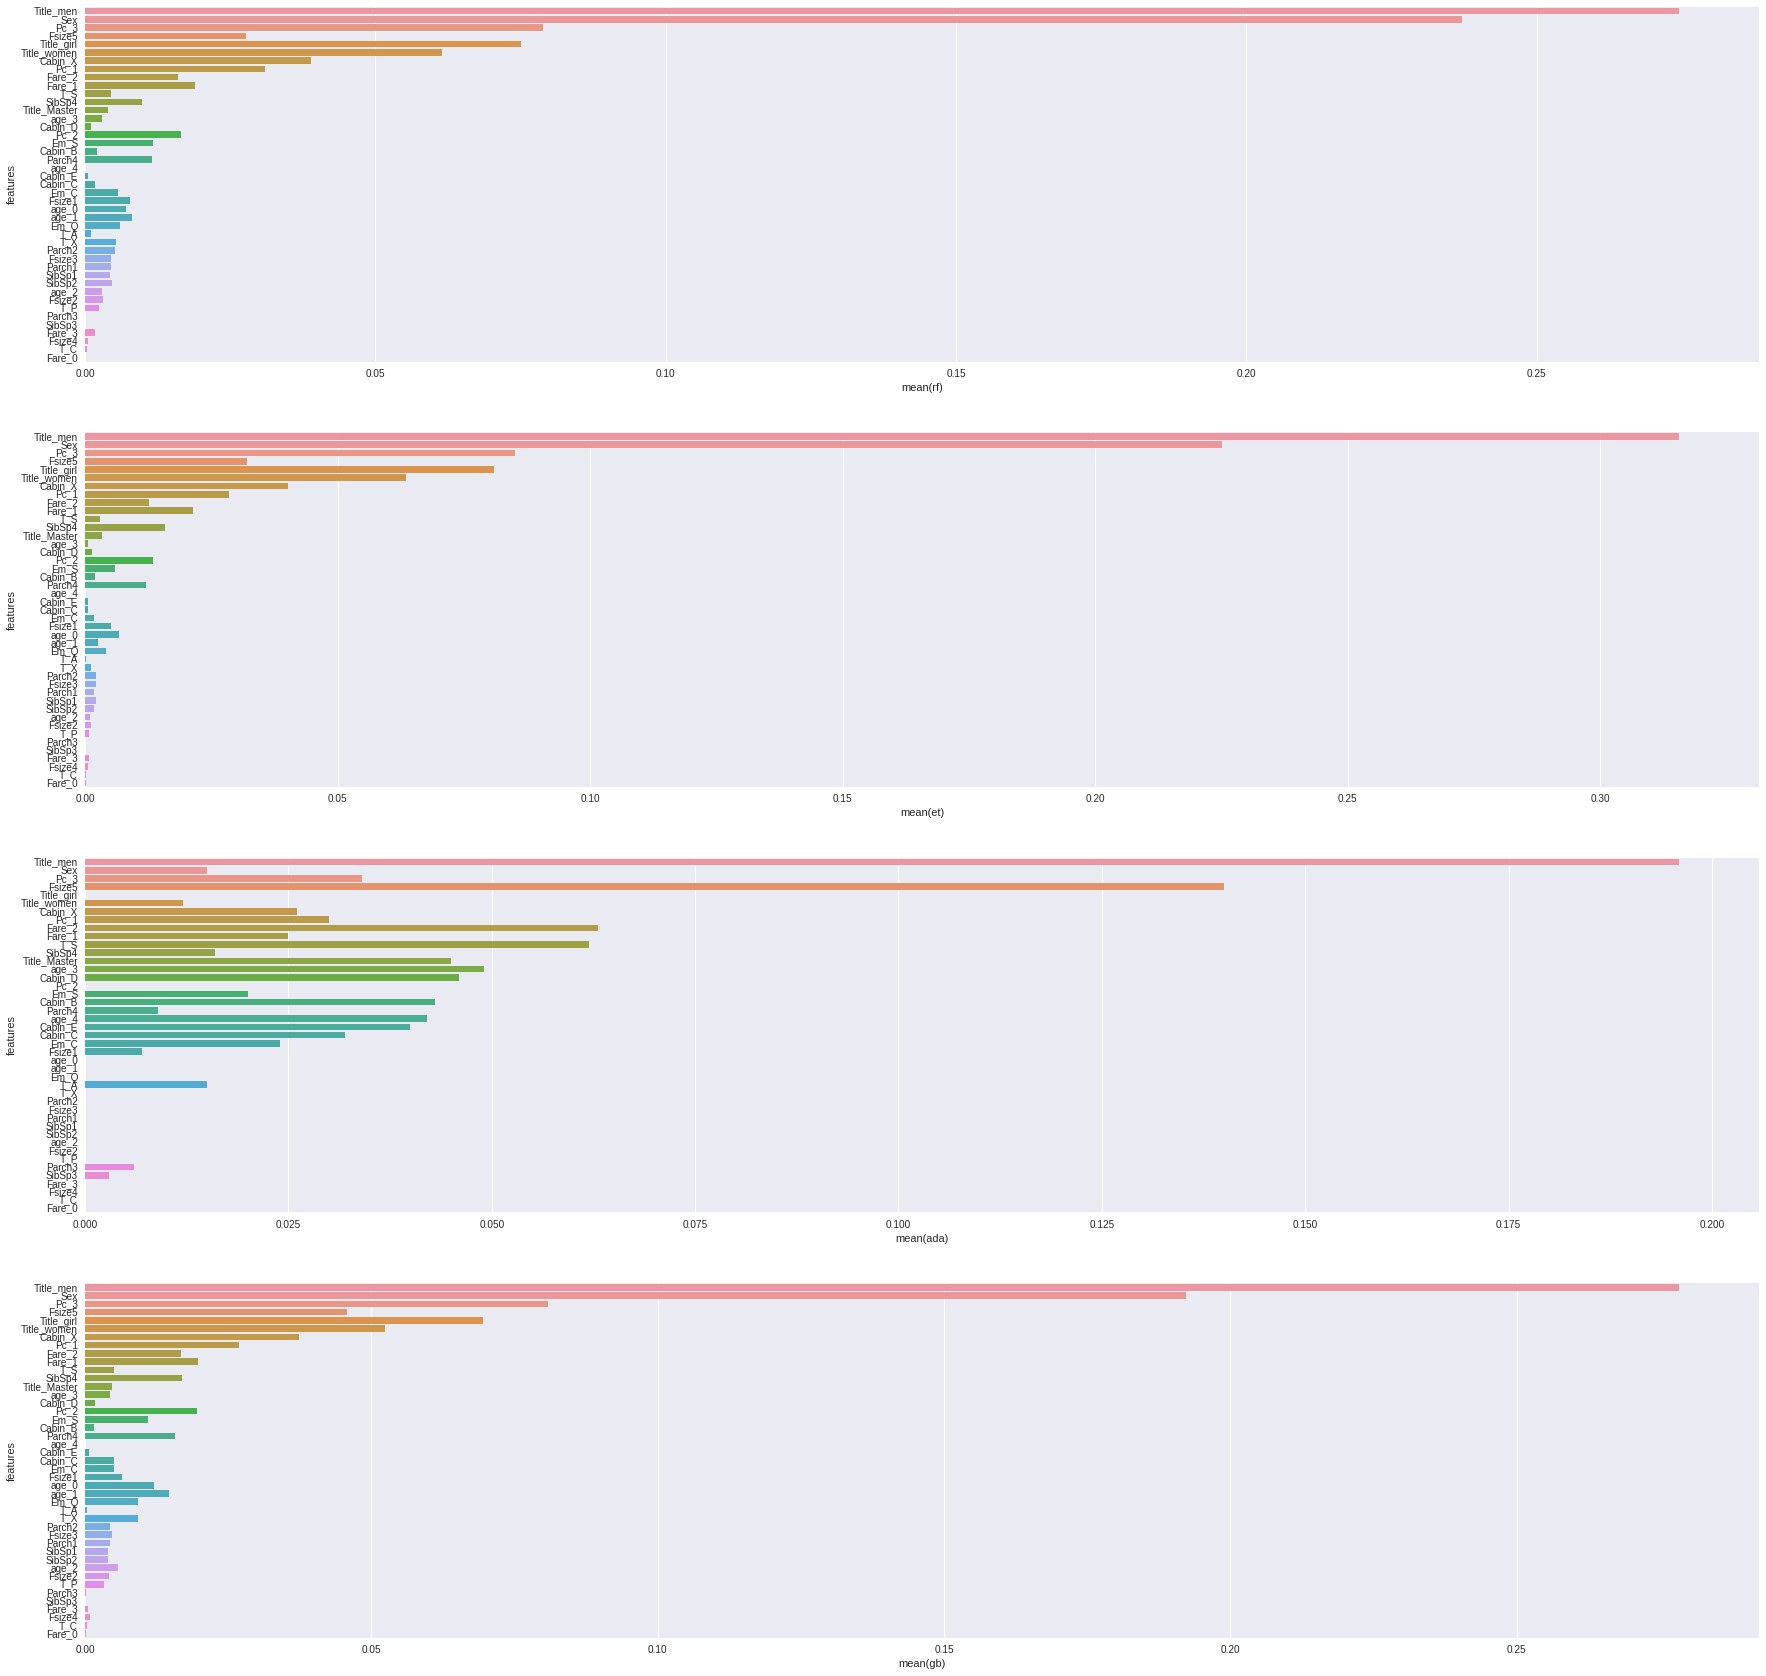

In [103]:
_,ax=plt.subplots(4,1,figsize=(30,30))
for i,classify in enumerate(important.columns.values[1:5:]):
    sns.barplot(y='features',x=classify,data=important,ax=ax[i])

In [117]:
print et_oof_train.shape
x_train_stack = np.concatenate(( et_oof_train, rf_oof_train,svc_oof_train), axis=1)
x_test_stack = np.concatenate(( et_oof_test, rf_oof_test,svc_oof_test), axis=1)
print x_train_stack.shape
print x_test_stack.shape

(881, 1)
(881, 3)
(418, 3)


In [118]:
gbm = xgb.XGBClassifier(
 learning_rate = 0.1,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train_stack, y_train)
print accuracy_score(gbm.predict(x_train_stack),y_train)
predictions = gbm.predict(x_test_stack)

0.83087400681


In [106]:
#print accuracy_score(ytest,predictions)

Just a quick run down of the XGBoost parameters used in the model:

**max_depth** : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**gamma** : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**eta** : step size shrinkage used in each boosting step to prevent overfitting

**Producing the Submission file**

Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:

In [119]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
'''StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': svc_oof_test.reshape(-1).astype(int)})'''

StackingSubmission.to_csv("titanic.csv", index=False)

**Steps for Further Improvement**

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels. 

Some additional steps that may be taken to improve one's score could be:

 1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
 2. Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.